<a href="https://colab.research.google.com/github/omerbokobza/DOAsAlgorithmsImpl/blob/main/RADAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MUSIC**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.linalg import svd

def music_algorithm(received_signals, num_antennas, num_sources, theta_range):
    # Calculate the covariance matrix of the received signals
    covariance_matrix = np.dot(received_signals, received_signals.conj().T) / received_signals.shape[1]

    # Eigenvalue decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Estimate noise subspace (N = num_antennas - num_sources eigenvectors)
    noise_subspace = eigenvectors[:, num_sources:]

    # Create steering vectors for DOA candidates
    num_samples = received_signals.shape[1]
    music_spectrum = np.zeros(len(theta_range))

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))

        # MUSIC spectrum calculation
        music_spectrum[i] = 1 / (np.linalg.norm(noise_subspace.conj().T @ a) ** 2)

    return music_spectrum

# Example usage:
# Define received_signals, num_antennas, num_sources, and theta_range
# music_spectrum = music_algorithm(received_signals, num_antennas, num_sources, theta_range)


In [ ]:
def esprit_algorithm(received_signals, num_antennas, num_sources):
    # Construct the signal subspace matrix using the received signals
    Y = np.linalg.svd(received_signals)[0][:, :num_sources]

    # Create the difference matrix
    Z = np.diff(Y, axis=1)

    # Perform eigen-decomposition of Z
    eigvals, eigvecs = np.linalg.eig(np.dot(Z, Z.conj().T))

    # Sort eigenvalues in ascending order
    sorted_indices = np.argsort(eigvals)
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Extract the phase angles from the eigenvectors
    angles = np.angle(eigvecs)

    # Calculate DOA estimates
    doa_estimates = -np.angle(angles) / (2 * np.pi)

    return doa_estimates

In [ ]:
def mvdr_algorithm(received_signals, num_antennas, num_sources, theta_range):
    # Calculate the covariance matrix of the received signals
    covariance_matrix = np.dot(received_signals, received_signals.conj().T) / received_signals.shape[1]
    reg_param = 1e-6
    covariance_matrix += reg_param * np.identity(num_antennas)
    # Create steering vectors for DOA candidates
    num_samples = received_signals.shape[1]
    mvdr_spectrum = np.zeros(len(theta_range))

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))

        # MVDR spectrum calculation
        numerator = 1 / np.dot(a.conj().T, np.linalg.solve(covariance_matrix, a))
        mvdr_spectrum[i] = np.real(numerator)

    return mvdr_spectrum

In [ ]:
def root_music_algorithm(received_signals, num_antennas, num_sources, theta_range):
    # Calculate the signal subspace using SVD
    U, S, _ = svd(received_signals)
    signal_subspace = U[:, num_sources:]

    # Create steering vectors for DOA candidates
    num_samples = received_signals.shape[1]
    root_music_spectrum = np.zeros(len(theta_range))

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))

        # Root-MUSIC spectrum calculation
        root_music_spectrum[i] = 1 / np.linalg.norm(signal_subspace.conj().T @ a)

    return root_music_spectrum

In [ ]:
def ls_algorithm(received_signals, num_antennas, num_sources, theta_range):
    # Create steering vectors for DOA candidates
    num_samples = received_signals.shape[1]
    ls_spectrum = np.zeros(len(theta_range))

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))

        # Calculate LS spectrum
        a_h = a.conj().T
        numerator = np.abs(np.matmul(a_h, received_signals)) ** 2
        denominator = np.matmul(a_h, a)
        ls_spectrum[i] = np.real(numerator / denominator)[0]

    return ls_spectrum


In [ ]:
def quantize_signal(signal, num_bits):
    # Perform quantization of the signal with a specified number of bits
    quantization_levels = 2 ** num_bits
    signal_range = np.max(np.abs(signal))
    step_size = signal_range / (quantization_levels - 1)
    quantized_signal = np.round(signal / step_size) * step_size
    return quantized_signal


In [ ]:
def music_algorithm_with_quantization(received_signals, num_antennas, num_sources, theta_range, quantization_bits):
    num_samples = received_signals.shape[1]

    # Quantize the received signals (real and imaginary parts separately)
    received_signals_quantized = quantize_signal(np.real(received_signals), quantization_bits) + \
                                  1j * quantize_signal(np.imag(received_signals), quantization_bits)

    # Continue with the rest of the algorithm
    covariance_matrix = np.dot(received_signals_quantized, received_signals_quantized.conj().T) / num_samples
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Estimate noise subspace (N = num_antennas - num_sources eigenvectors)
    noise_subspace = eigenvectors[:, num_sources:]

    # Create steering vectors for DOA candidates
    music_spectrum = np.zeros(len(theta_range), dtype=float)  # Initialize as float

    for i, theta in enumerate(theta_range):
        # Steering vector for the given DOA
        a = np.exp(-1j * 2 * np.pi * np.sin(theta) * np.arange(num_antennas))
        # MUSIC spectrum calculation
        numerator = np.sum(np.abs(np.matmul(noise_subspace.conj().T, a)) ** 2)


        denominator = np.sum(np.abs(np.matmul(eigenvectors.conj().T, a)) ** 2)  # Total power
        music_spectrum[i] = 1.0 - numerator / denominator

    return music_spectrum

In [ ]:
# # Function to calculate Mean Squared Error (MSE)
def calculate_mse(true_DOAs, estimated_DOAs):
    mse_values = []
    for true_DOA in true_DOAs:
        # Find the estimated DOA that is closest to the true DOA
       closest_estimated_DOA = estimated_DOAs[np.argmin(np.abs(estimated_DOAs - true_DOA))]
       print(closest_estimated_DOA)
      #  print(true_DOA)
       mse = (true_DOA - closest_estimated_DOA) ** 2
       mse_values.append(mse)
    return np.mean(mse_values)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
num_antennas = 8
num_samples = 1000
num_sources = 2
quantization_bits = 2 # Number of bits for quantization
theta_range = np.linspace(-np.pi / 2, np.pi / 2, 180)

# Define true DOAs and source amplitudes
true_DOAs = [0.1, -0.4]#, 0.5,-0.9]  # True DOA angles in radians
amplitudes = [1.2, 0.3]#, 0.6,1.4]  # Amplitudes of sources

# Create a uniform linear antenna array
antenna_spacing = 0.5
array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * antenna_spacing)

# Initialize arrays to store MSE results for each algorithm
mse_results = []

# Generate received signals (original, unquantized)
np.random.seed(0)
noise = np.random.randn(num_antennas, num_samples) + 1j * np.random.randn(num_antennas, num_samples)
received_signals_original = np.zeros((num_antennas, num_samples), dtype=complex)

for i in range(num_sources):
    source_signal = amplitudes[i] * np.exp(1j * 2 * np.pi * np.sin(true_DOAs[i]) * np.arange(num_samples))
    received_signals_original += np.outer(array_response, source_signal)

# Add noise to the received signals
noise_power = 10 ** (-10 / 10)  # Noise power (adjust SNR as needed)
received_signals_original += np.sqrt(noise_power) * noise


# Perform DOA estimation with each algorithm
estimated_DOAs_music = music_algorithm(received_signals_original, num_antennas, num_sources, theta_range)
estimated_DOAs_root_music = root_music_algorithm(received_signals_original, num_antennas, num_sources, theta_range)
estimated_DOAs_mvdr = mvdr_algorithm(received_signals_original, num_antennas, num_sources, theta_range)
estimated_DOAs_ls = ls_algorithm(received_signals_original, num_antennas, num_sources, theta_range)
estimated_DOAs_esprit = esprit_algorithm(received_signals_original, num_antennas, num_sources)

# Quantize the received signals
received_signals_quantized = quantize_signal(received_signals_original, quantization_bits)

# Perform DOA estimation with quantized signals using each algorithm
estimated_DOAs_music_quantized = music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range)
estimated_DOAs_root_music_quantized = root_music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range)
estimated_DOAs_mvdr_quantized = mvdr_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range)
estimated_DOAs_ls_quantized = ls_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range)
estimated_DOAs_esprit_quantized = esprit_algorithm(received_signals_quantized, num_antennas, num_sources)

# Calculate MSE for each algorithm (quantized and unquantized)
mse_music = calculate_mse(true_DOAs, estimated_DOAs_music)
mse_root_music = calculate_mse(true_DOAs, estimated_DOAs_root_music)
mse_mvdr = calculate_mse(true_DOAs, estimated_DOAs_mvdr)
mse_ls = calculate_mse(true_DOAs, estimated_DOAs_ls)
mse_esprit = calculate_mse(true_DOAs, estimated_DOAs_esprit)

mse_music_quantized = calculate_mse(true_DOAs, estimated_DOAs_music_quantized)
mse_root_music_quantized = calculate_mse(true_DOAs, estimated_DOAs_root_music_quantized)
mse_mvdr_quantized = calculate_mse(true_DOAs, estimated_DOAs_mvdr_quantized)
mse_ls_quantized = calculate_mse(true_DOAs, estimated_DOAs_ls_quantized)
mse_esprit_quantized = calculate_mse(true_DOAs, estimated_DOAs_esprit_quantized)

# Store MSE results
mse_results.append({
    "Algorithm": "MUSIC",
    "Unquantized": mse_music,
    "Quantized": mse_music_quantized
})
mse_results.append({
    "Algorithm": "root-MUSIC",
    "Unquantized": mse_root_music,
    "Quantized": mse_root_music_quantized
})
mse_results.append({
    "Algorithm": "MVDR",
    "Unquantized": mse_mvdr,
    "Quantized": mse_mvdr_quantized
})
mse_results.append({
    "Algorithm": "LS",
    "Unquantized": mse_ls,
    "Quantized": mse_ls_quantized
})
mse_results.append({
    "Algorithm": "ESPRIT",
    "Unquantized": mse_esprit,
    "Quantized": mse_esprit_quantized
})

0.12530933231108532
0.12530933231108532
0.35399058223501934
0.35399058223501934
0.09495971111815829
0.023502800804136328
0.09701668891684738
0.0038521022420643252
[-0.  -0.5 -0.5 -0.5 -0.  -0.  -0.5 -0. ]
[-0.  -0.  -0.5 -0.  -0.  -0.  -0.5 -0.5]
0.12775261124693635
0.12775261124693635
0.3574249728921275
0.3574249728921275
0.08787922474734633
0.037493038524075144
0.10459419181455507
0.0014418262308989946
[-0.  -0.5 -0.  -0.  -0.  -0.5 -0.5 -0.5]
[-0.5 -0.5 -0.5 -0.5 -0.5 -0.  -0.5 -0.5]


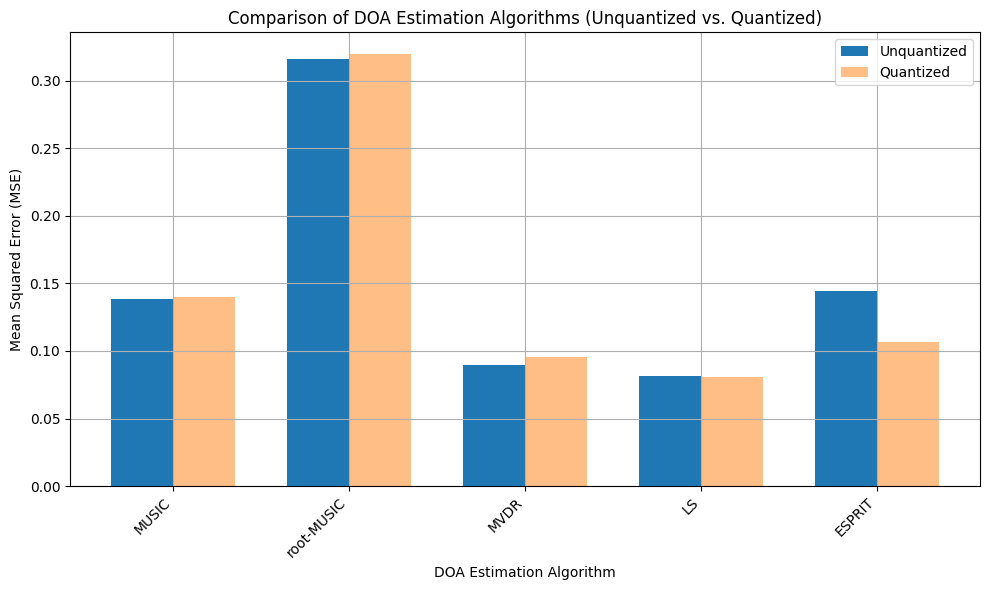

In [ ]:
# Plot and compare the MSE results
plt.figure(figsize=(10, 6))
algorithm_names = [result["Algorithm"] for result in mse_results]
num_algorithms = len(algorithm_names)

# Width of each bar
bar_width = 0.35

# Calculate the x-axis positions for bars (quantized and unquantized)
x_unquantized = np.arange(num_algorithms)
x_quantized = x_unquantized + bar_width

# Extract the MSE values for unquantized and quantized cases
unquantized_mse_values = [result["Unquantized"] for result in mse_results]
quantized_mse_values = [result["Quantized"] for result in mse_results]

# Create bar plots for unquantized and quantized MSE values
plt.bar(x_unquantized, unquantized_mse_values, width=bar_width, label="Unquantized")
plt.bar(x_quantized, quantized_mse_values, width=bar_width, label="Quantized", alpha=0.5)

# Set x-axis labels and tick positions
plt.xlabel("DOA Estimation Algorithm")
plt.xticks(x_unquantized + bar_width / 2, algorithm_names, rotation=45, ha="right")

# Label for the y-axis
plt.ylabel("Mean Squared Error (MSE)")

# Title and legend
plt.title("Comparison of DOA Estimation Algorithms (Unquantized vs. Quantized)")
plt.legend()

# Gridlines
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

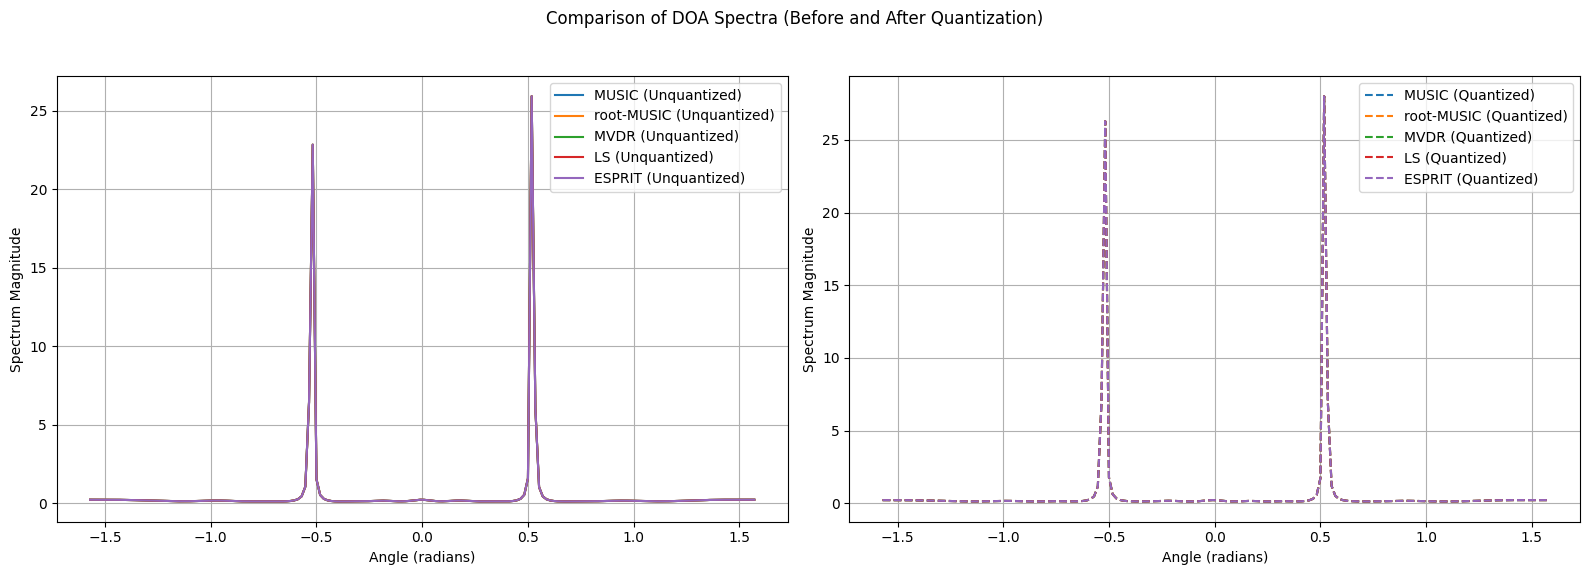

In [ ]:
# Create subplots for DOA spectra (before and after quantization)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Comparison of DOA Spectra (Before and After Quantization)")

for algorithm_name in algorithm_names:
    unquantized_spectrum = np.abs(music_algorithm(received_signals_original, num_antennas, num_sources, theta_range))
    quantized_spectrum = np.abs(music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range))

    # Subplot for unquantized signals
    axs[0].plot(theta_range, unquantized_spectrum, label=f"{algorithm_name} (Unquantized)")

    # Subplot for quantized signals
    axs[1].plot(theta_range, quantized_spectrum, label=f"{algorithm_name} (Quantized)", linestyle='--')

# Set common x and y labels
for ax in axs:
    ax.set_xlabel("Angle (radians)")
    ax.set_ylabel("Spectrum Magnitude")
    ax.grid(True)
    ax.legend()

# Adjust layout and show plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

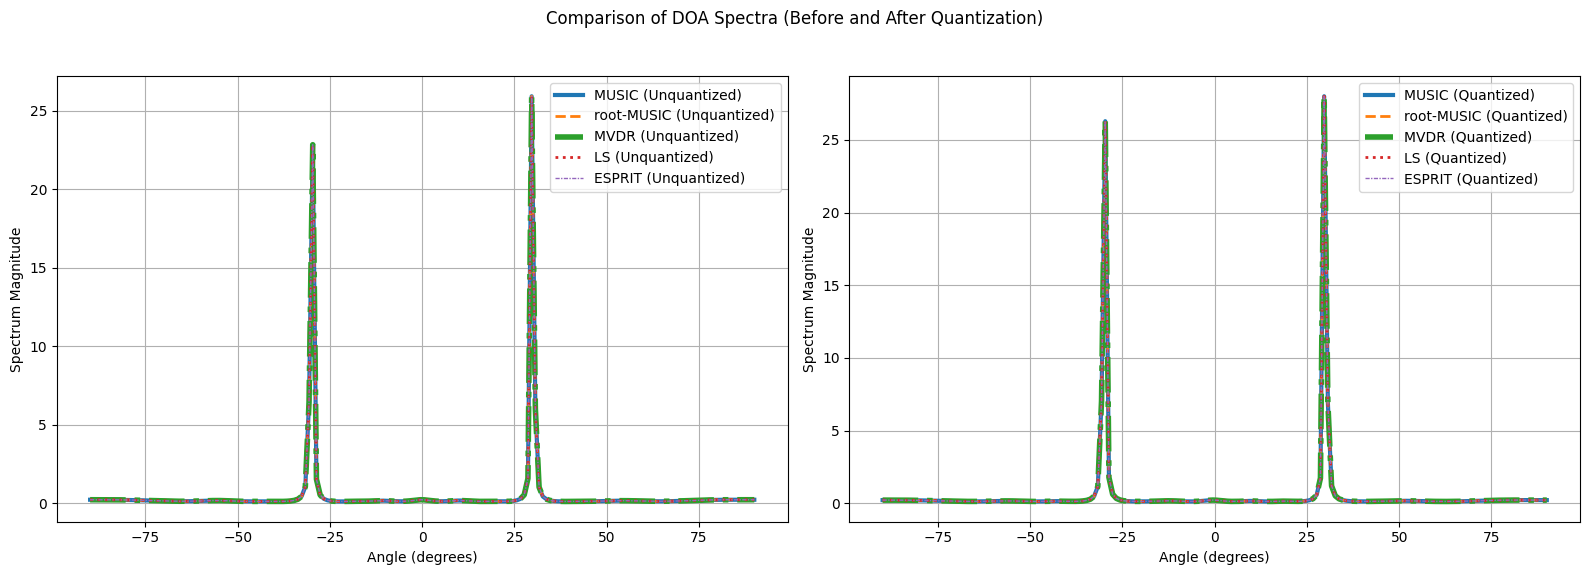

In [ ]:
theta_range_degrees = np.degrees(theta_range)

# Create subplots for DOA spectra (before and after quantization)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Comparison of DOA Spectra (Before and After Quantization)")

for i, algorithm_name in enumerate(algorithm_names):
    unquantized_spectrum = np.abs(music_algorithm(received_signals_original, num_antennas, num_sources, theta_range))
    quantized_spectrum = np.abs(music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range))

    # Define linestyles and linewidths here
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # Add more linestyles as needed
    linewidths = [3, 2, 4, 2, 1]  # Set linewidths here

    # Subplot for unquantized signals
    axs[0].plot(theta_range_degrees, unquantized_spectrum, label=f"{algorithm_name} (Unquantized)",
                linestyle=linestyles[i], linewidth=linewidths[i])

    # Subplot for quantized signals
    axs[1].plot(theta_range_degrees, quantized_spectrum, label=f"{algorithm_name} (Quantized)",
                linestyle=linestyles[i], linewidth=linewidths[i])

# Set common x and y labels with degrees
for ax in axs:
    ax.set_xlabel("Angle (degrees)")
    ax.set_ylabel("Spectrum Magnitude")
    ax.grid(True)
    ax.legend()

# Adjust layout and show plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

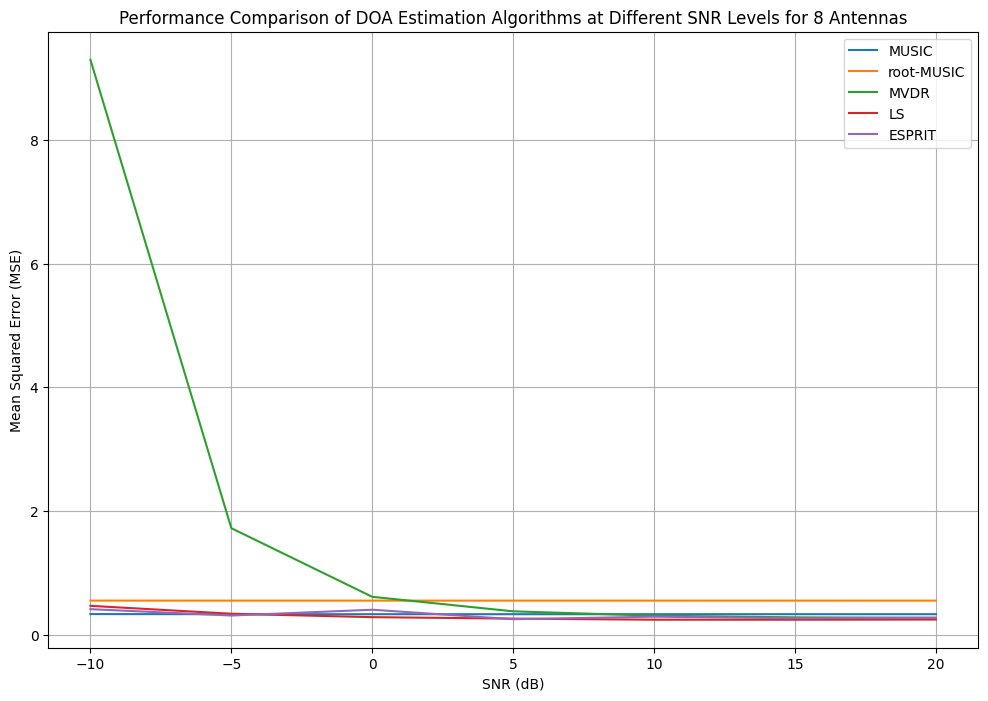

In [ ]:
# Define a range of SNR values (in dB) to test
snr_values_db = np.arange(-10, 21, 5)

# Initialize arrays to store MSE results for each algorithm at different SNR levels
mse_results_snr = {algorithm_name: [] for algorithm_name in algorithm_names}

for snr_db in snr_values_db:
    # Calculate noise power based on SNR (adjust as needed)
    noise_power = 10 ** (-snr_db / 10)

    # Generate received signals with the current SNR
    received_signals_snr = received_signals_original + np.sqrt(noise_power) * noise

    # Perform DOA estimation with each algorithm
    estimated_DOAs = {
        "MUSIC": music_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "root-MUSIC": root_music_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_snr, num_antennas, num_sources)
    }

    # Calculate MSE for each algorithm and store the results
    for algorithm_name, estimated_DOA in estimated_DOAs.items():
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_snr[algorithm_name].append(mse)

# Create a plot to compare MSE values at different SNR levels for each algorithm
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(snr_values_db, mse_results_snr[algorithm_name], label=algorithm_name)

plt.xlabel("SNR (dB)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"Performance Comparison of DOA Estimation Algorithms at Different SNR Levels for {num_antennas} Antennas")
plt.legend()
plt.grid(True)
plt.show()


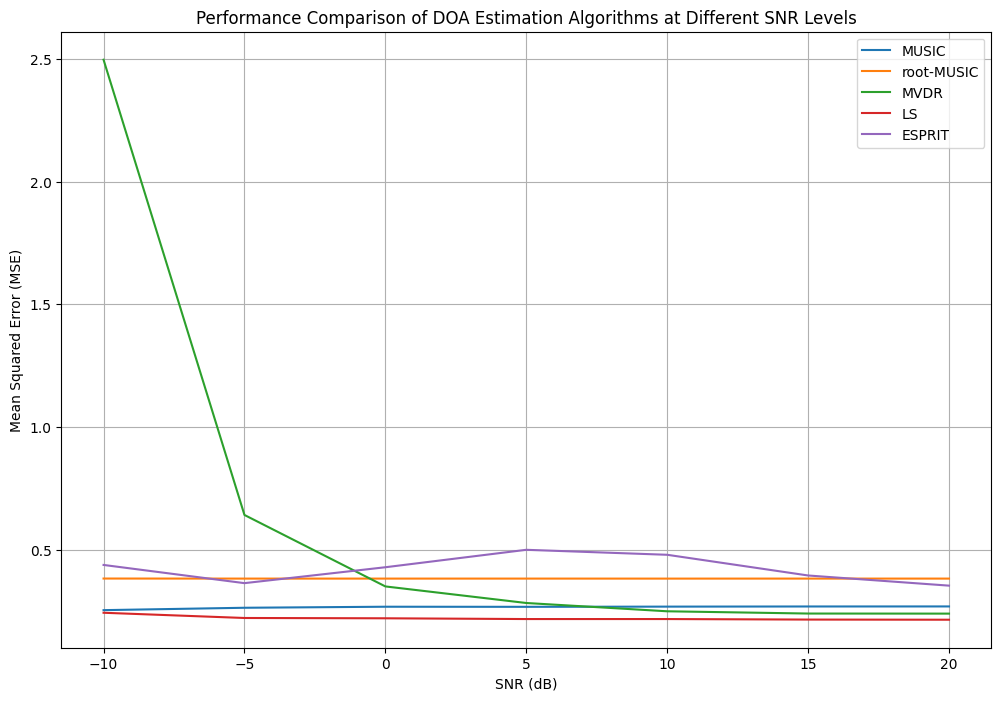

In [ ]:
# AFTER QUANTIZATION

snr_values_db = np.arange(-10, 21, 5)

# Initialize arrays to store MSE results for each algorithm at different SNR levels
mse_results_snr = {algorithm_name: [] for algorithm_name in algorithm_names}

for snr_db in snr_values_db:
    # Calculate noise power based on SNR (adjust as needed)
    noise_power = 10 ** (-snr_db / 10)

    # Generate received signals with the current SNR (quantized)
    received_signals_snr = received_signals_quantized + np.sqrt(noise_power) * noise

    # Perform DOA estimation with each algorithm (quantized)
    estimated_DOAs = {
        "MUSIC": music_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "root-MUSIC": root_music_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_snr, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_snr, num_antennas, num_sources)
    }

    # Calculate MSE for each algorithm and store the results
    for algorithm_name, estimated_DOA in estimated_DOAs.items():
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_snr[algorithm_name].append(mse)

# Create a plot to compare MSE values at different SNR levels for each algorithm
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(snr_values_db, mse_results_snr[algorithm_name], label=algorithm_name)

plt.xlabel("SNR (dB)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Performance Comparison of DOA Estimation Algorithms at Different SNR Levels")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-40-14c0244498d5>:30: RuntimeWarning: divide by zero encountered in double_scalars
  music_spectrum[i] = 1 / (np.linalg.norm(noise_subspace.conj().T @ a) ** 2)
<ipython-input-43-88aefcc28cec>:15: RuntimeWarning: divide by zero encountered in double_scalars
  root_music_spectrum[i] = 1 / np.linalg.norm(signal_subspace.conj().T @ a)


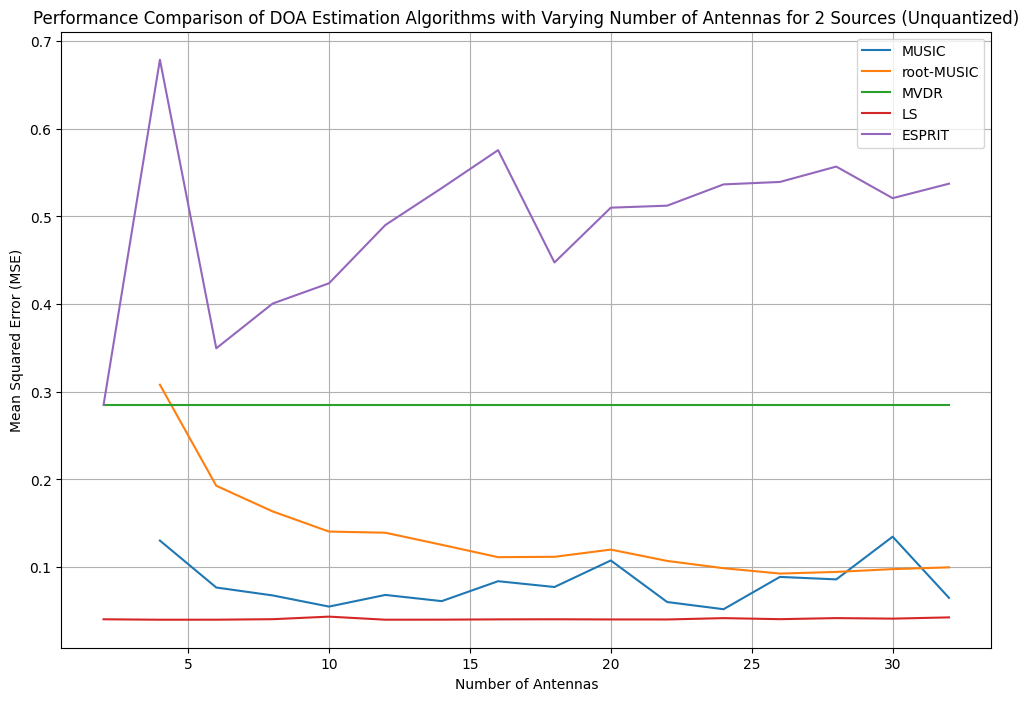

In [ ]:
# num of anntenas switch UNQUANTIZED
snr_db = 10
# Define a range of antenna counts to test
antenna_counts = np.arange(2, 33, 2)


# Initialize arrays to store MSE results for each algorithm at different antenna counts (unquantized)
mse_results_antenna_unquantized = {algorithm_name: [] for algorithm_name in algorithm_names}

for num_antennas in antenna_counts:
    # Create a uniform linear antenna array with the current number of antennas
    array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * antenna_spacing)

    # Initialize arrays to store received signals and noise for this scenario (unquantized)
    received_signals_original = np.zeros((num_antennas, num_samples), dtype=complex)
    noise = np.zeros((num_antennas, num_samples), dtype=complex)

    for i in range(num_sources):
        source_signal = amplitudes[i] * np.exp(1j * 2 * np.pi * np.sin(true_DOAs[i]) * np.arange(num_samples))
        received_signals_original += np.outer(array_response, source_signal)

    # Generate noise for this scenario (unquantized)
    noise_power = 10 ** (-snr_db / 10)
    noise = np.sqrt(noise_power) * (np.random.randn(num_antennas, num_samples) + 1j * np.random.randn(num_antennas, num_samples))

    # Calculate the covariance matrix of the received signals (unquantized)
    covariance_matrix = np.dot(received_signals_original, received_signals_original.conj().T) / num_samples

    # Eigenvalue decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Estimate noise subspace (N = num_antennas - num_sources eigenvectors)
    noise_subspace = eigenvectors[:, num_sources:]

    # Perform DOA estimation with each algorithm (unquantized)
    estimated_DOAs_unquantized = {
        "MUSIC": music_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "root-MUSIC": root_music_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_original, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_original, num_antennas, num_sources)
    }

    # Calculate MSE for each algorithm and store the results (unquantized)
    for algorithm_name, estimated_DOA in estimated_DOAs_unquantized.items():
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_antenna_unquantized[algorithm_name].append(mse)

# Create a plot to compare MSE values with different numbers of antennas for each algorithm (unquantized)
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(antenna_counts, mse_results_antenna_unquantized[algorithm_name], label=algorithm_name)

plt.xlabel("Number of Antennas")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"Performance Comparison of DOA Estimation Algorithms with Varying Number of Antennas for {num_sources} Sources (Unquantized)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# num of anntenas switch QUANTIZED
snr_db = 10
# Define a range of antenna counts to test
antenna_counts = np.arange(2, 33, 2)

# Initialize arrays to store MSE results for each algorithm at different antenna counts (quantized)
mse_results_antenna_quantized = {algorithm_name: [] for algorithm_name in algorithm_names}

for num_antennas in antenna_counts:
    # Create a uniform linear antenna array with the current number of antennas
    array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * antenna_spacing)

    # Initialize arrays to store received signals and noise for this scenario (quantized)
    received_signals_quantized = np.zeros((num_antennas, num_samples), dtype=complex)
    noise = np.zeros((num_antennas, num_samples), dtype=complex)

    for i in range(num_sources):
        source_signal = amplitudes[i] * np.exp(1j * 2 * np.pi * np.sin(true_DOAs[i]) * np.arange(num_samples))
        received_signals_quantized += np.outer(array_response, source_signal)

    # Apply quantization to the received signals (quantized)
    received_signals_quantized = quantize_signal(received_signals_quantized, quantization_bits)

    # Generate noise for this scenario (quantized)
    noise_power = 10 ** (-snr_db / 10)
    noise = np.sqrt(noise_power) * (np.random.randn(num_antennas, num_samples) + 1j * np.random.randn(num_antennas, num_samples))

    # Calculate the covariance matrix of the received signals (quantized)
    covariance_matrix = np.dot(received_signals_quantized, received_signals_quantized.conj().T) / num_samples

    # Eigenvalue decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Estimate noise subspace (N = num_antennas - num_sources eigenvectors)
    noise_subspace = eigenvectors[:, num_sources:]

    # Perform DOA estimation with each algorithm (quantized)
    estimated_DOAs_quantized = {
        "MUSIC": music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "root-MUSIC": root_music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_quantized, num_antennas, num_sources)
    }

    # Calculate MSE for each algorithm and store the results (quantized)
    for algorithm_name, estimated_DOA in estimated_DOAs_quantized.items():
        print(true_DOAs)
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_antenna_quantized[algorithm_name].append(mse)

# Create a plot to compare MSE values with different numbers of antennas for each algorithm (quantized)
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(antenna_counts, mse_results_antenna_quantized[algorithm_name], label=algorithm_name)

plt.xlabel("Number of Antennas")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"Performance Comparison of DOA Estimation Algorithms with Varying Number of Antennas for {num_sources} Sources (Quantized)")
plt.legend()
plt.grid(True)
plt.show()


[0.1, -0.4]
inf
inf
[0.1, -0.4]
inf
inf
[0.1, -0.4]
0.001964746130509575
4.999999999591101e-07
[0.1, -0.4]
0.10789414120708642
6.748919021978358e-32
[0.1, -0.4]
[-0. -0.]


<ipython-input-40-14c0244498d5>:30: RuntimeWarning: divide by zero encountered in double_scalars
  music_spectrum[i] = 1 / (np.linalg.norm(noise_subspace.conj().T @ a) ** 2)
<ipython-input-43-88aefcc28cec>:15: RuntimeWarning: divide by zero encountered in double_scalars
  root_music_spectrum[i] = 1 / np.linalg.norm(signal_subspace.conj().T @ a)


IndexError: ignored

In [ ]:
# Define a range of quantization bits to test
quantization_bits_range = np.arange(2, 13)

# Initialize arrays to store MSE results for each algorithm at different quantization bits
mse_results_quantization_bits = {algorithm_name: [] for algorithm_name in algorithm_names}

for quantization_bits in quantization_bits_range:
    # Quantize the received signals with the current number of bits
    received_signals_quantized = quantize_signal(received_signals_original, quantization_bits)

    # Perform DOA estimation with each algorithm (quantized)
    estimated_DOAs_quantized = {
        "MUSIC": music_algorithm_with_quantization(received_signals_quantized, num_antennas, num_sources, theta_range, quantization_bits=quantization_bits),
        "root-MUSIC": root_music_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "MVDR": mvdr_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "LS": ls_algorithm(received_signals_quantized, num_antennas, num_sources, theta_range),
        "ESPRIT": esprit_algorithm(received_signals_quantized, num_antennas, num_sources)
    }

    # Calculate MSE for each algorithm and store the results
    for algorithm_name, estimated_DOA in estimated_DOAs_quantized.items():
        mse = calculate_mse(true_DOAs, estimated_DOA)
        mse_results_quantization_bits[algorithm_name].append(mse)

# Create a plot to compare MSE values at different quantization bits for each algorithm
plt.figure(figsize=(12, 8))
for algorithm_name in algorithm_names:
    plt.plot(quantization_bits_range, mse_results_quantization_bits[algorithm_name], label=algorithm_name)

plt.xlabel("Quantization Bits")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"Performance Comparison of DOA Estimation Algorithms at Different Quantization Bits for {num_antennas} Antennas and {num_sources} Sources")
plt.legend()
plt.grid(True)
plt.show()


ValueError: ignored

In [ ]:
# # Simulated parameters
# num_antennas = 32
# num_samples = 1000
# num_sources = 2
# SNR_dB = 10
# quantization_bits = 2  # Number of bits for quantization
# theta_range = np.linspace(-np.pi / 2, np.pi / 2, 180)

# # Define true DOAs and source amplitudes
# true_DOAs = [0.1, -0.4,0.4,0.9]  # True DOA angles in radians
# amplitudes = [1.2, 0.6,0.6,0.2]  # Amplitudes of sources

# # Create a uniform linear antenna array
# antenna_spacing = 0.5
# array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * antenna_spacing)

# # Generate received signals (original, unquantized)
# np.random.seed(0)
# noise = np.random.randn(num_antennas, num_samples) + 1j * np.random.randn(num_antennas, num_samples)
# received_signals_original = np.zeros((num_antennas, num_samples), dtype=complex)

# for i in range(num_sources):
#     source_signal = amplitudes[i] * np.exp(1j * 2 * np.pi * np.sin(true_DOAs[i]) * np.arange(num_samples))
#     received_signals_original += np.outer(array_response, source_signal)

# # Add noise to the received signals
# noise_power = 10 ** (-SNR_dB / 10)  # Noise power
# received_signals_original += np.sqrt(noise_power) * noise

# # Run both the original MUSIC algorithm and the modified algorithm with quantization
# music_spectrum_original = music_algorithm(received_signals_original, num_antennas, num_sources, theta_range)
# music_spectrum_quantized = music_algorithm_with_quantization(received_signals_original, num_antennas, num_sources, theta_range, quantization_bits)



# threshold_original = 0.5  # Adjust the threshold as needed
# threshold_quantized = 0.5  # Adjust the threshold as needed

# # Original MUSIC algorithm
# peaks, _ = find_peaks(music_spectrum_original, height=0.5)
# estimated_DOAs_original = theta_range[peaks]
# print("Estimated DOAs (Original):", estimated_DOAs_original)

# # Modified algorithm with quantization
# peaks2, _ = find_peaks(music_spectrum_quantized, height=0.5)
# estimated_DOAs_quantized = theta_range[peaks2]
# print("Estimated DOAs (Quantized):", estimated_DOAs_quantized)

# # Plot and compare the results with estimated DOAs
# plt.figure(figsize=(12, 6))

# plt.subplot(2, 1, 1)
# plt.plot(np.degrees(theta_range), music_spectrum_original, label="MUSIC Spectrum (Original)")
# plt.plot(np.degrees(estimated_DOAs_original), music_spectrum_original[peaks], 'ro', label="Estimated DOAs Vanilla")
# plt.xlabel("DOA (degrees)")
# plt.ylabel("MUSIC Spectrum")
# plt.title("Original MUSIC Algorithm")
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 1, 2)
# plt.plot(np.degrees(theta_range), music_spectrum_quantized, label=f"MUSIC Spectrum (Quantized - {quantization_bits} bits)")
# plt.plot(np.degrees(estimated_DOAs_quantized), music_spectrum_quantized[peaks], 'ro', label="Estimated DOAs Quantized")
# plt.xlabel("DOA (degrees)")
# plt.ylabel("MUSIC Spectrum")
# plt.title("Modified Algorithm with Quantization")
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()


#**DOA - Deep Learning Approach**

In [ ]:
def generate_data(num_samples, num_antennas, num_sources, signal_dim):
    # Simulate received signals with known DOAs
    received_signals = []
    true_doas = []

    for _ in range(num_samples):
        true_doa = np.sort(np.random.uniform(0, np.pi, num_sources))
        received_signal = np.zeros((num_antennas, signal_dim), dtype=complex)

        for source_idx, source_doa in enumerate(true_doa):
            array_response = np.exp(1j * 2 * np.pi * np.arange(num_antennas) * np.sin(source_doa))
            source_signal = np.random.randn(signal_dim) + 1j * np.random.randn(signal_dim)
            received_signal += array_response[:, np.newaxis] @ source_signal[np.newaxis, :]

        received_signals.append(received_signal)
        true_doas.append(true_doa)

    return np.array(received_signals), np.array(true_doas)

Epoch 1/50
38/38 [==============================] - 1s 4ms/step - loss: 1.6850
Epoch 2/50
38/38 [==============================] - 0s 3ms/step - loss: 0.5017
Epoch 3/50
38/38 [==============================] - 0s 3ms/step - loss: 0.1292
Epoch 4/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0572
Epoch 5/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0297
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0197
Epoch 7/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 8/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 9/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0350
Epoch 10/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0542
Epoch 11/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0672
Epoch 12/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0745
Epoch 13/50
38/38 [==============================

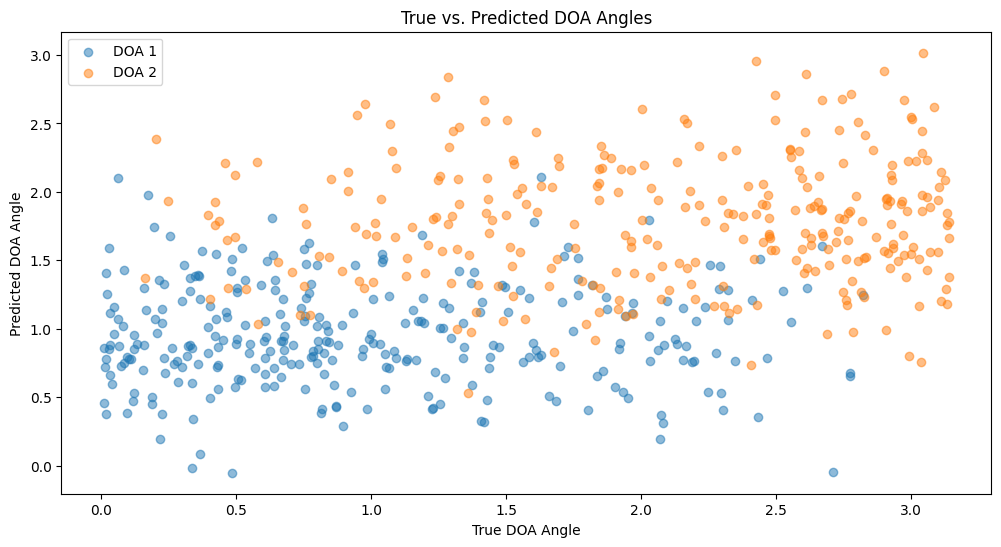

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Generate your data with the same number of samples as used for training and testing
num_samples = 1500  # Adjust the number of samples
num_antennas = 16
num_sources = 2
signal_dim = 100

received_signals, true_doas = generate_data(num_samples, num_antennas, num_sources, signal_dim)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(received_signals, true_doas, test_size=0.2, random_state=42)

# Use only the real parts of the received signals
X_train_real = np.real(X_train)
X_test_real = np.real(X_test)

# Define a function to build your neural network model
def build_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Flatten the input data
X_train_flat = X_train_real.reshape(X_train_real.shape[0], -1)
X_test_flat = X_test_real.reshape(X_test_real.shape[0], -1)

# Standardize input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Create and train the neural network model
model = build_model(X_train_scaled.shape[1], y_train.shape[1])
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate Mean Squared Error for each DOA angle
mse = mean_squared_error(y_test, y_pred)

desired_num_samples = 300  # Adjust to the number of samples you want

if true_doas.shape[0] > desired_num_samples:
    true_doas = true_doas[:desired_num_samples, :]
    y_pred = y_pred[:desired_num_samples, :]
elif true_doas.shape[0] < desired_num_samples:
    # Repeat data to match the desired number of samples
    repeat_factor = desired_num_samples // true_doas.shape[0]
    remainder_samples = desired_num_samples % true_doas.shape[0]

    true_doas = np.concatenate([true_doas] * repeat_factor, axis=0)
    y_pred = np.concatenate([y_pred] * repeat_factor, axis=0)

    # If there are remaining samples to add, take them from the beginning
    if remainder_samples > 0:
        true_doas = np.concatenate((true_doas, true_doas[:remainder_samples, :]), axis=0)
        y_pred = np.concatenate((y_pred, y_pred[:remainder_samples, :]), axis=0)

# Plot the true and predicted DOA angles
plt.figure(figsize=(12, 6))
plt.scatter(true_doas[:, 0], y_pred[:, 0], label='DOA 1', alpha=0.5)
plt.scatter(true_doas[:, 1], y_pred[:, 1], label='DOA 2', alpha=0.5)
plt.xlabel('True DOA Angle')
plt.ylabel('Predicted DOA Angle')
plt.legend()
plt.title('True vs. Predicted DOA Angles')
plt.show()


10/10 [==============================] - 0s 2ms/step


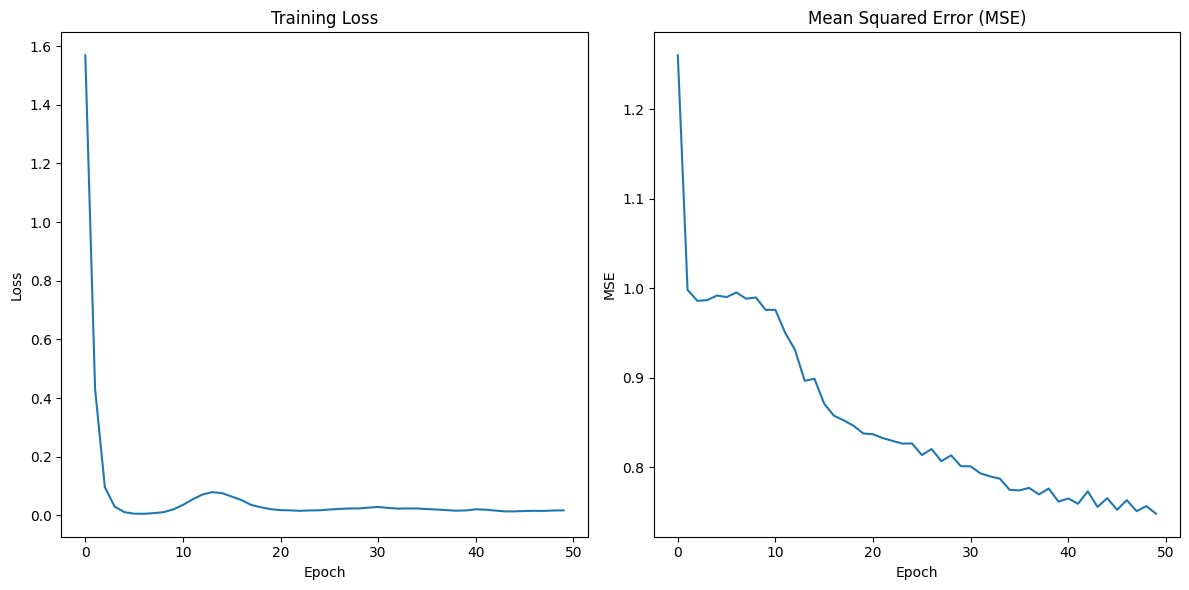

In [ ]:
model = build_model(X_train_scaled.shape[1], y_train.shape[1])

# Create lists to store loss and MSE during training
loss_history = []
mse_history = []

for epoch in range(50):  # Train for 50 epochs
    history = model.fit(X_train_scaled, y_train, epochs=1, batch_size=32, verbose=0)  # Train for 1 epoch
    loss = history.history['loss'][0]

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate Mean Squared Error for each DOA angle
    mse = mean_squared_error(y_test, y_pred)

    # Append the loss and MSE to their respective lists
    loss_history.append(loss)
    mse_history.append(mse)

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot the MSE
plt.subplot(1, 2, 2)
plt.plot(mse_history)
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for neural network predictions
mse_nn = mean_squared_error(true_doas, y_pred)

In [ ]:
rmse_nn = np.sqrt(mse_nn)
rmse_music = np.sqrt(mse_music)
rmse_root_music = np.sqrt(mse_root_music)
rmse_mvdr = np.sqrt(mse_mvdr)
rmse_ls = np.sqrt(mse_ls)
rmse_esprit = np.sqrt(mse_esprit)

rmse_music_q = np.sqrt(mse_music_quantized)
rmse_root_music_q = np.sqrt(mse_root_music_quantized)
rmse_mvdr_q = np.sqrt(mse_mvdr_quantized)
rmse_ls_q = np.sqrt(mse_ls_quantized)
rmse_esprit_q = np.sqrt(mse_esprit_quantized)

print(f"RMSE for Neural Network: {rmse_nn:.4f}")
print(f"RMSE for MUSIC Algorithm: {rmse_music:.4f}")
print(f"RMSE for ROOT MUSIC Algorithm: {rmse_root_music:.4f}")
print(f"RMSE for LS Algorithm: {rmse_ls:.4f}")
print(f"RMSE for ESPRIT Algorithm: {rmse_esprit:.4f}")

print(f"RMSE for QUANTIZED MUSIC Algorithm: {rmse_music_q:.4f}")
print(f"RMSE for QUANTIZED ROOT MUSIC Algorithm: {rmse_root_music_q:.4f}")
print(f"RMSE for QUANTIZED MVDR Algorithm: {rmse_mvdr_q:.4f}")
print(f"RMSE for QUANTIZED LS Algorithm: {rmse_ls_q:.4f}")
print(f"RMSE for QUANTIZED ESPRIT Algorithm: {rmse_esprit_q:.4f}")

print(f'AND THE WINNER IS!:{min(rmse_nn,rmse_music,rmse_root_music,rmse_mvdr,rmse_ls,rmse_esprit,rmse_music_q,rmse_root_music_q,rmse_mvdr_q,rmse_ls_q,rmse_esprit_q)}')

RMSE for Neural Network: 0.8779
RMSE for MUSIC Algorithm: 0.3719
RMSE for ROOT MUSIC Algorithm: 0.5626
RMSE for LS Algorithm: 0.2856
RMSE for ESPRIT Algorithm: 0.3800
RMSE for QUANTIZED MUSIC Algorithm: 0.3737
RMSE for QUANTIZED ROOT MUSIC Algorithm: 0.5657
RMSE for QUANTIZED MVDR Algorithm: 0.3095
RMSE for QUANTIZED LS Algorithm: 0.2839
RMSE for QUANTIZED ESPRIT Algorithm: 0.3269
AND THE WINNER IS!:0.28388082574033446
